In [20]:
import re
import csv
from collections import defaultdict
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tabulate import tabulate

This jupyter script analayzes the simulation input file by:  
1) Analyzing the frequency of locations usage in orders  
2) Categorizing locations into different groups  
3) Visulazing all the orders as a Directed Graph 

In [21]:
# ---------------------------------------------
# Analyze the frequency of locations usage in orders
# ---------------------------------------------

# Load the "ContainerOrders" sheet into a DataFrame
df = pd.read_excel("VOSimu-InputInformation.xlsx", sheet_name="ContainerOrders")

# Ensure the required columns exist
required_columns = ["OriginLocation", "DestinationLocation"]
missing_columns = [col for col in required_columns if col not in df.columns]

if not missing_columns:
    # Count occurrences of each Origin and Destination location (ignoring NaNs)
    origin_counts = df["OriginLocation"].dropna().value_counts()
    destination_counts = df["DestinationLocation"].dropna().value_counts()

    # Combine both counts into a single DataFrame
    location_counts = pd.DataFrame({"Origin Count": origin_counts, "Destination Count": destination_counts})
    location_counts.fillna(0, inplace=True)  # Replace NaN with 0 where a location appears in only one category

    # Display the top 10 most used locations
    print("\nTop 10 Most Frequently Used Locations:\n")
    print(tabulate(location_counts.head(10), headers="keys", tablefmt="pretty"))

else:
    print(f"Error: Missing required columns: {missing_columns}")


Top 10 Most Frequently Used Locations:

+-------------+--------------+-------------------+
|             | Origin Count | Destination Count |
+-------------+--------------+-------------------+
|    QC001    |     12.0     |        0.0        |
|    QC003    |     52.0     |        0.0        |
|    QC004    |     18.0     |        0.0        |
|    QC005    |     97.0     |        0.0        |
|    QC006    |     61.0     |        0.0        |
|    QC007    |     27.0     |        0.0        |
| RAIL001.01  |     3.0      |        0.0        |
| RAIL001.02  |     1.0      |        0.0        |
| RAIL001.101 |     1.0      |        0.0        |
| RAIL001.109 |     1.0      |        0.0        |
+-------------+--------------+-------------------+


In [22]:
# ---------------------------------------------
# Categorize locations into different groups
# ---------------------------------------------


# Create the YARD list
YARD = [f"YARD001.{str(i).zfill(2)}" for i in range(1, 70)] + \
       [f"YARD002.{str(i).zfill(2)}" for i in range(1, 14)] + \
       [f"YARD003.{str(i).zfill(2)}" for i in range(1, 5)]

# Create the RAIL list
RAIL = [f"RAIL001.{str(i).zfill(2)}" for i in range(1, 110)]

WS = [f"WS{str(i).zfill(3)}.01" for i in range(1, 18)]

QC = ["QC001","QC003","QC004","QC005","QC006","QC007"]

C:\Users\miravani\AppData\Local\Temp\ipykernel_31316\340909481.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_locations = df_locations.applymap(lambda x: x.strip() if isinstance(x, str) else x)
C:\Users\miravani\AppData\Local\Temp\ipykernel_31316\340909481.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_orders = df_orders.applymap(lambda x: x.strip() if isinstance(x, str) else x)


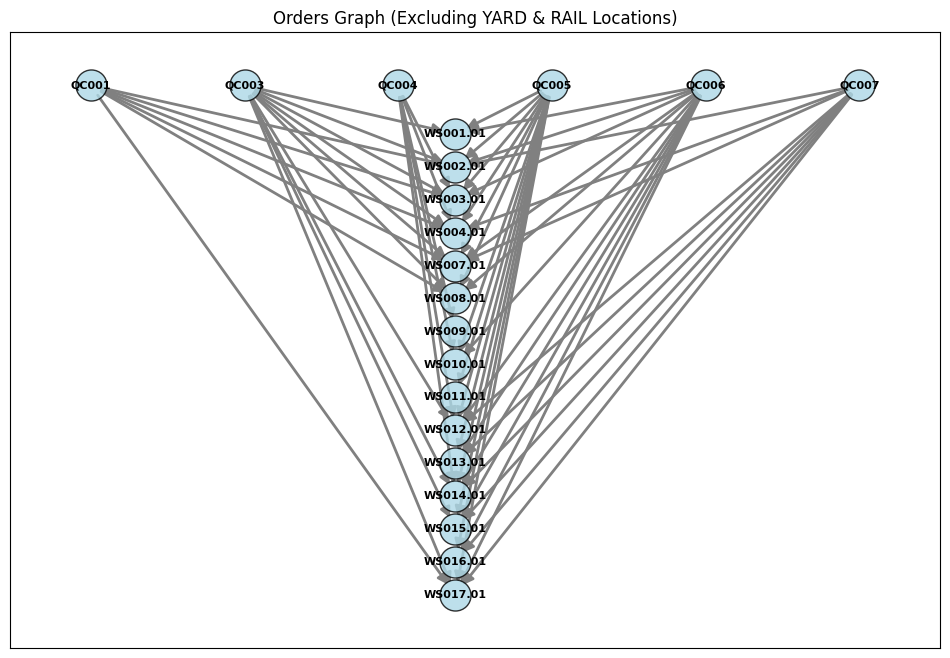

In [23]:
# ---------------------------------------------
# Create a Directed Graph from the list of all locations and the edges as movements of all container orders
# ---------------------------------------------

# Read input Excel files
df_locations = pd.read_excel("VOSimu-InputInformation.xlsx", sheet_name="Locations")
df_orders = pd.read_excel("VOSimu-InputInformation.xlsx", sheet_name="ContainerOrders")

# Clean data: Strip whitespace from string columns
df_locations = df_locations.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_orders = df_orders.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Rename columns for clarity
df_locations.rename(columns={"Location Name": "Location", "X-Coordinate [mm]": "X", "Y-Coordinate [mm]": "Y"}, inplace=True)

# Remove YARD and RAIL locations from df_locations for readability
df_locations = df_locations[~df_locations["Location"].isin(YARD + RAIL)]

# Remove orders where either the Origin or Destination is in YARD or RAIL
df_orders = df_orders[
    (~df_orders["OriginLocation"].isin(YARD + RAIL)) & 
    (~df_orders["DestinationLocation"].isin(YARD + RAIL))
]

# Merge to get coordinates for the Origin and Destination
df_orders = df_orders.merge(df_locations, left_on="OriginLocation", right_on="Location", how="left")
df_orders.rename(columns={"X": "X_Origin", "Y": "Y_Origin"}, inplace=True)
df_orders = df_orders.merge(df_locations, left_on="DestinationLocation", right_on="Location", how="left")
df_orders.rename(columns={"X": "X_Dest", "Y": "Y_Dest"}, inplace=True)

# Create a Directed Graph
G = nx.DiGraph()

# Add nodes with locations
pos = {row["Location"]: (row["X"], row["Y"]) for _, row in df_locations.iterrows()}
G.add_nodes_from(pos.keys())

# Add directed edges for order movements
edge_labels = {}  # Dictionary to store edge labels
for _, row in df_orders.iterrows():
    if pd.notna(row["X_Origin"]) and pd.notna(row["X_Dest"]):  
        G.add_edge(row["OriginLocation"], row["DestinationLocation"])
        #edge_labels[(row["OriginLocation"], row["DestinationLocation"])] = f"{row['TractorOrderId']}"  # Label edges with order ID

# Visualize the Movement Graph
plt.figure(figsize=(12, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue", edgecolors="black", alpha=0.8)

# Draw edges with arrows
nx.draw_networkx_edges(G, pos, edge_color="gray", arrowstyle="-|>", arrowsize=15, width=2)

# Add labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, font_color="red", rotate=False)

# Set title and show the plot
plt.title("Orders Graph (Excluding YARD & RAIL Locations)")
plt.show()


C:\Users\miravani\AppData\Local\Temp\ipykernel_31316\3163715025.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_locations = df_locations.applymap(lambda x: x.strip() if isinstance(x, str) else x)
C:\Users\miravani\AppData\Local\Temp\ipykernel_31316\3163715025.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_orders = df_orders.applymap(lambda x: x.strip() if isinstance(x, str) else x)


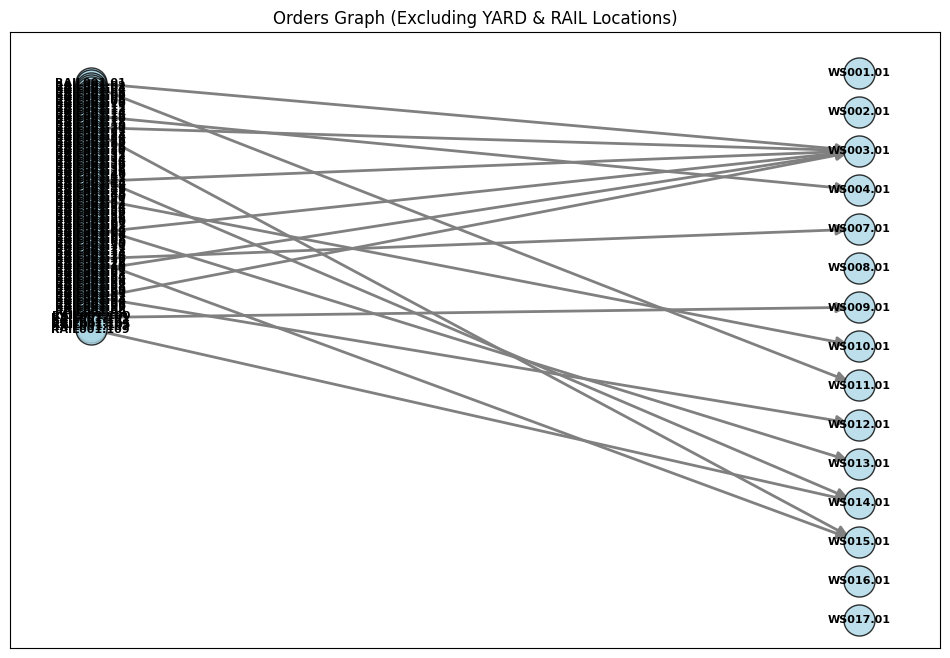

In [24]:
# ---------------------------------------------
# Create a Directed Graph from the list of all locations and the edges as movements of all container orders
# ---------------------------------------------

# Read input Excel files
df_locations = pd.read_excel("VOSimu-InputInformation.xlsx", sheet_name="Locations")
df_orders = pd.read_excel("VOSimu-InputInformation.xlsx", sheet_name="ContainerOrders")

# Clean data: Strip whitespace from string columns
df_locations = df_locations.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_orders = df_orders.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Rename columns for clarity
df_locations.rename(columns={"Location Name": "Location", "X-Coordinate [mm]": "X", "Y-Coordinate [mm]": "Y"}, inplace=True)

# Remove YARD and QC locations from df_locations for readability
df_locations = df_locations[~df_locations["Location"].isin(YARD + QC)]

# Remove orders where either the Origin or Destination is in YARD or RAIL
df_orders = df_orders[
    (~df_orders["OriginLocation"].isin(YARD + QC)) & 
    (~df_orders["DestinationLocation"].isin(YARD + QC))
]

# Merge to get coordinates for the Origin and Destination
df_orders = df_orders.merge(df_locations, left_on="OriginLocation", right_on="Location", how="left")
df_orders.rename(columns={"X": "X_Origin", "Y": "Y_Origin"}, inplace=True)
df_orders = df_orders.merge(df_locations, left_on="DestinationLocation", right_on="Location", how="left")
df_orders.rename(columns={"X": "X_Dest", "Y": "Y_Dest"}, inplace=True)

# Create a Directed Graph
G = nx.DiGraph()

# Add nodes with locations
pos = {row["Location"]: (row["X"], row["Y"]) for _, row in df_locations.iterrows()}
G.add_nodes_from(pos.keys())

# Add directed edges for order movements
edge_labels = {}  # Dictionary to store edge labels
for _, row in df_orders.iterrows():
    if pd.notna(row["X_Origin"]) and pd.notna(row["X_Dest"]):  
        G.add_edge(row["OriginLocation"], row["DestinationLocation"])
        #edge_labels[(row["OriginLocation"], row["DestinationLocation"])] = f"{row['TractorOrderId']}"  # Label edges with order ID

# Visualize the Movement Graph
plt.figure(figsize=(12, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue", edgecolors="black", alpha=0.8)

# Draw edges with arrows
nx.draw_networkx_edges(G, pos, edge_color="gray", arrowstyle="-|>", arrowsize=15, width=2)

# Add labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, font_color="red", rotate=False)

# Set title and show the plot
plt.title("Orders Graph (Excluding YARD & RAIL Locations)")
plt.show()


C:\Users\miravani\AppData\Local\Temp\ipykernel_31316\1828066627.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_locations = df_locations.applymap(lambda x: x.strip() if isinstance(x, str) else x)
C:\Users\miravani\AppData\Local\Temp\ipykernel_31316\1828066627.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_orders = df_orders.applymap(lambda x: x.strip() if isinstance(x, str) else x)


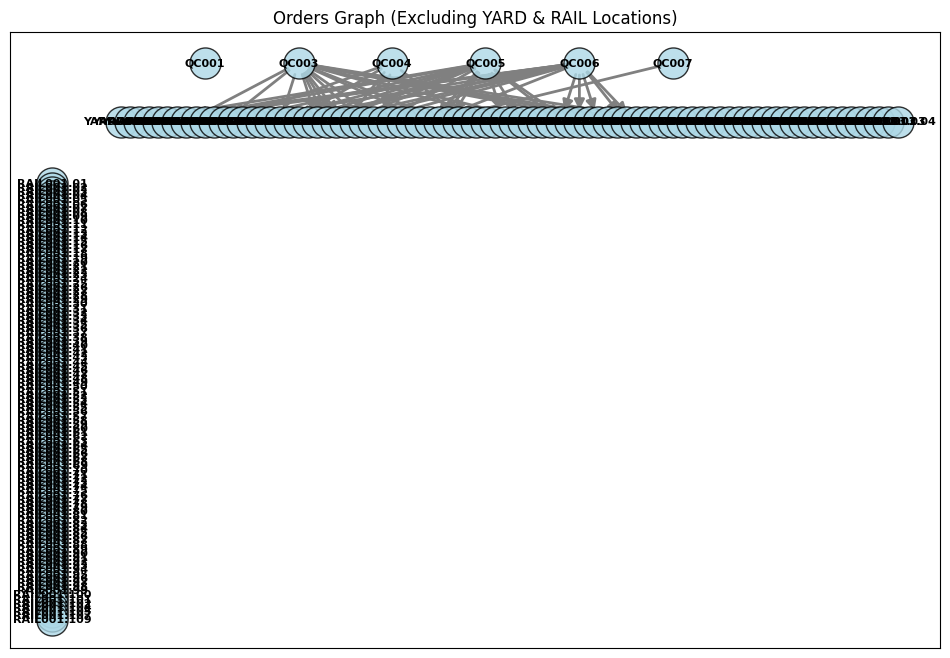

In [25]:
# ---------------------------------------------
# Create a Directed Graph from the list of all locations and the edges as movements of all container orders
# ---------------------------------------------

# Read input Excel files
df_locations = pd.read_excel("VOSimu-InputInformation.xlsx", sheet_name="Locations")
df_orders = pd.read_excel("VOSimu-InputInformation.xlsx", sheet_name="ContainerOrders")

# Clean data: Strip whitespace from string columns
df_locations = df_locations.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_orders = df_orders.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Rename columns for clarity
df_locations.rename(columns={"Location Name": "Location", "X-Coordinate [mm]": "X", "Y-Coordinate [mm]": "Y"}, inplace=True)

# Remove WS locations from df_locations for readability
df_locations = df_locations[~df_locations["Location"].isin(WS)]

# Remove orders where either the Origin or Destination is in YARD or RAIL
df_orders = df_orders[
    (~df_orders["OriginLocation"].isin(WS)) & 
    (~df_orders["DestinationLocation"].isin(WS))
]

# Merge to get coordinates for the Origin and Destination
df_orders = df_orders.merge(df_locations, left_on="OriginLocation", right_on="Location", how="left")
df_orders.rename(columns={"X": "X_Origin", "Y": "Y_Origin"}, inplace=True)
df_orders = df_orders.merge(df_locations, left_on="DestinationLocation", right_on="Location", how="left")
df_orders.rename(columns={"X": "X_Dest", "Y": "Y_Dest"}, inplace=True)

# Create a Directed Graph
G = nx.DiGraph()

# Add nodes with locations
pos = {row["Location"]: (row["X"], row["Y"]) for _, row in df_locations.iterrows()}
G.add_nodes_from(pos.keys())

# Add directed edges for order movements
edge_labels = {}  # Dictionary to store edge labels
for _, row in df_orders.iterrows():
    if pd.notna(row["X_Origin"]) and pd.notna(row["X_Dest"]):  
        G.add_edge(row["OriginLocation"], row["DestinationLocation"])
        #edge_labels[(row["OriginLocation"], row["DestinationLocation"])] = f"{row['TractorOrderId']}"  # Label edges with order ID

# Visualize the Movement Graph
plt.figure(figsize=(12, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue", edgecolors="black", alpha=0.8)

# Draw edges with arrows
nx.draw_networkx_edges(G, pos, edge_color="gray", arrowstyle="-|>", arrowsize=15, width=2)

# Add labels
nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, font_color="red", rotate=False)

# Set title and show the plot
plt.title("Orders Graph (Excluding YARD & RAIL Locations)")
plt.show()
